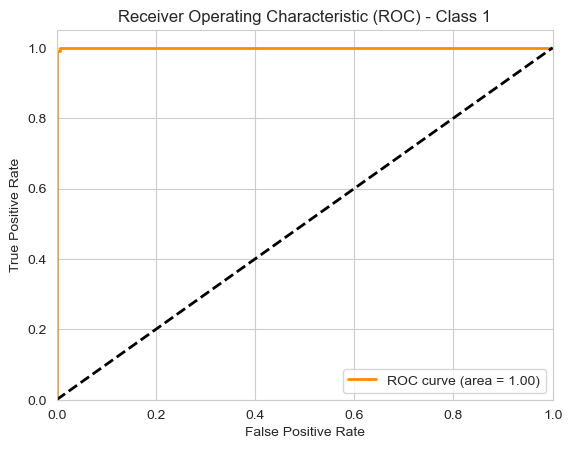

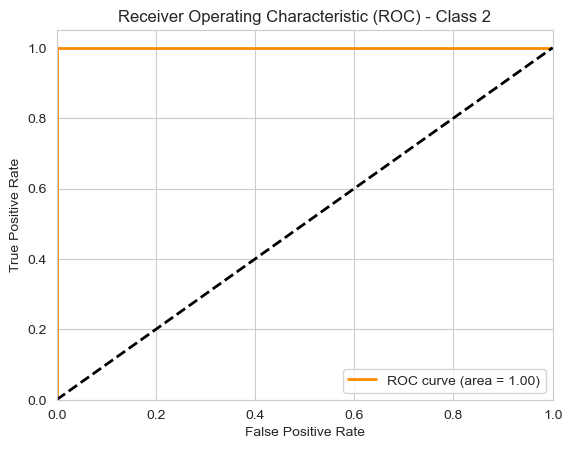

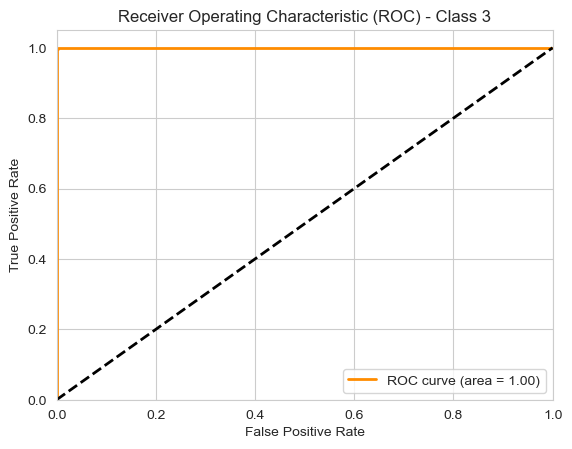

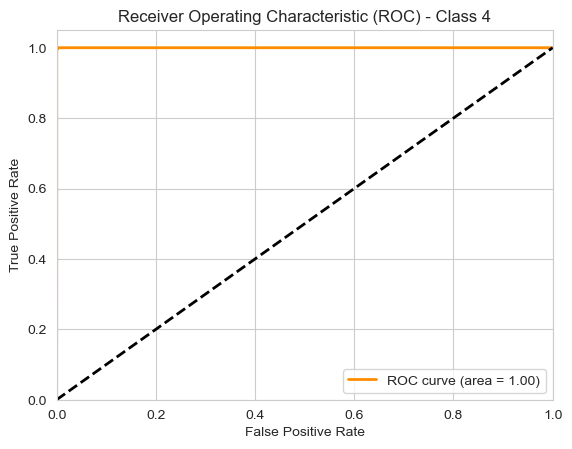

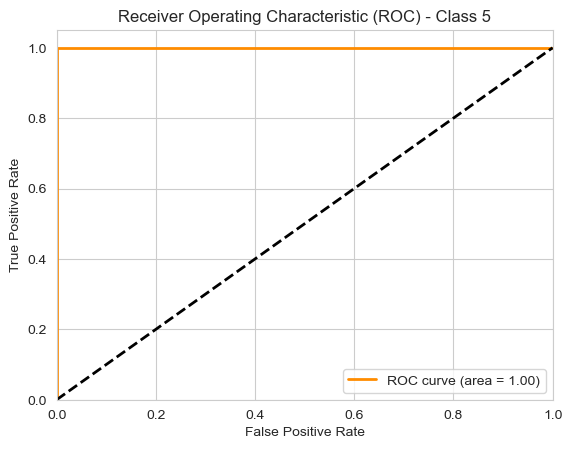

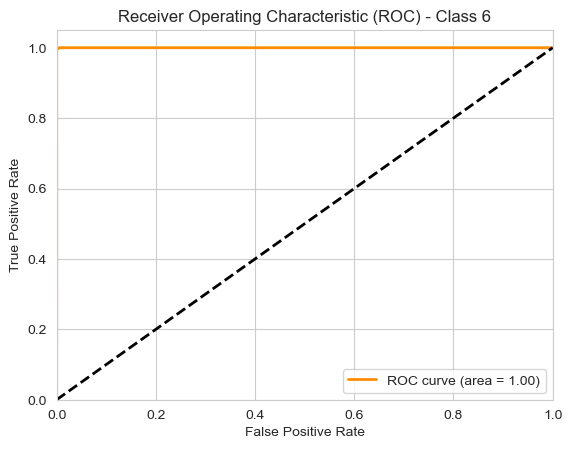

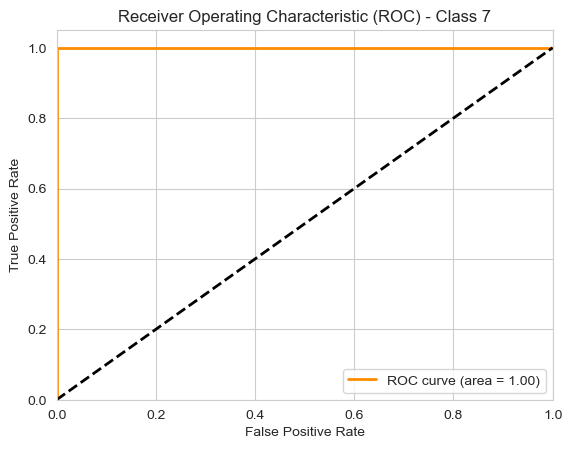

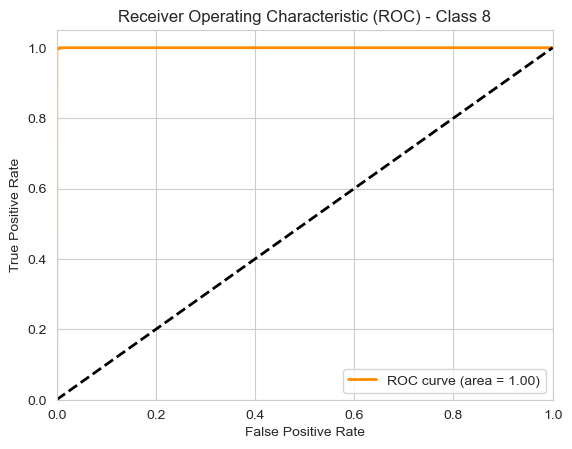

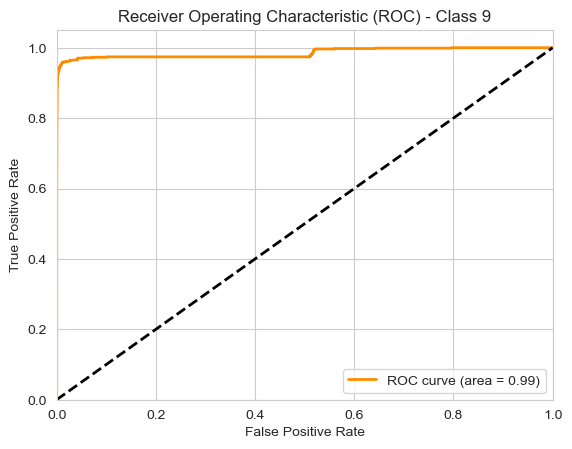

Classification Report:
              precision    recall  f1-score   support

           1      0.987     0.997     0.992       868
           2      0.990     1.000     0.995       801
           3      0.995     0.997     0.996       792
           4      0.986     0.998     0.992       846
           5      0.989     0.999     0.994       867
           6      0.990     0.998     0.994       819
           7      0.991     0.998     0.994       845
           8      0.991     0.995     0.993       818
           9      0.990     0.929     0.959       848

    accuracy                          0.990      7504
   macro avg      0.990     0.990     0.990      7504
weighted avg      0.990     0.990     0.990      7504



In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import ADASYN
import numpy as np

# 加载数据
data = pd.read_csv('cleaned_all_data_processed.csv')

# 准备数据
X = data[['age_at_event mean', 'Average Net Result mean', 'Mark mean', 
          'Mark min', 'Mark var', 'current_match_ranking mean', 
          'current_match_ranking min', 'Average Rank mean', 'efficiency mean', 'Nat', 'Years to Olympics']]
y = data['Olympic Ranking']

# 使用ADASYN进行过采样
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 定义随机森林分类器
rf_classifier = RandomForestClassifier(random_state=42)

# 调整多层感知机分类器参数
param_grid = {
    'hidden_layer_sizes': [(100,), (200,), (200, 100), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPClassifier(max_iter=300, random_state=42)
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 使用最佳参数重新定义MLP分类器
mlp_classifier = grid_search.best_estimator_

# 定义投票分类器
voting_classifier = VotingClassifier(estimators=[('rf', rf_classifier), ('mlp', mlp_classifier)], voting='soft')

# 训练投票分类器
voting_classifier.fit(X_train, y_train)

# 预测概率
y_score = voting_classifier.predict_proba(X_test)

# 计算每个类别的ROC曲线和AUC
n_classes = len(np.unique(y))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    y_test_bin = label_binarize(y_test, classes=np.unique(y))
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # 单独绘制每个类别的ROC曲线
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=2,
             label='ROC curve (area = {:.2f})'.format(roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Class {}'.format(i + 1))
    plt.legend(loc="lower right")
    plt.show()

# 输出分类报告（宏平均和加权平均）
y_pred = voting_classifier.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1, digits=3, 
                            labels=[1, 2, 3, 4, 5, 6, 7, 8, 9], 
                            target_names=['1', '2', '3', '4', '5', '6', '7', '8', '9']))

In [11]:

# 加载新的数据集
new_data = pd.read_csv('candidate_processed2.csv')

# 过滤出 Year 为 2024 的记录
new_data_2024 = new_data[new_data['Year'] == 2024]

# 确保新数据集的特征和训练数据一致
X_new_2024 = new_data_2024[['age_at_event mean', 'Average Net Result mean', 'Mark mean', 
                            'Mark min', 'Mark var', 'current_match_ranking mean', 
                            'current_match_ranking min', 'Average Rank mean', 'efficiency mean', 'Nat', 'Years to Olympics']]

# 使用已经训练好的投票分类器进行预测
new_predictions_2024 = voting_classifier.predict(X_new_2024)

# 输出预测结果
new_data_2024['Predicted Olympic Ranking'] = new_predictions_2024
print(new_data_2024[['Year', 'Predicted Olympic Ranking']])

# 如果需要将预测结果保存到新的CSV文件
new_data_2024.to_csv('candidate_predictions_2024_improved.csv', index=False)


    Year  Predicted Olympic Ranking
2   2024                          9
6   2024                          9
9   2024                          4
12  2024                          9
16  2024                          9
21  2024                          8
25  2024                          2
28  2024                          1
32  2024                          9
36  2024                          9
39  2024                          1
42  2024                          9
46  2024                          9
51  2024                          9
56  2024                          9
59  2024                          9
63  2024                          9
67  2024                          9


C:\Users\86133\AppData\Local\Temp\ipykernel_4008\693201119.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data_2024['Predicted Olympic Ranking'] = new_predictions_2024


In [15]:
# 加载新的数据集
new_data = pd.read_csv('candidate_processed2.csv')

# 确保新数据集的特征和训练数据一致
X_new = new_data[['age_at_event mean', 'Average Net Result mean', 'Mark mean', 
                  'Mark min', 'Mark var', 'current_match_ranking mean', 
                  'current_match_ranking min', 'Average Rank mean', 'efficiency mean', 'Nat', 'Years to Olympics']]

# 使用已经训练好的投票分类器进行预测
new_predictions = voting_classifier.predict(X_new)

# 输出预测结果
new_data['Predicted Olympic Ranking'] = new_predictions
print(new_data[['Predicted Olympic Ranking']])

# 如果需要将预测结果保存到新的CSV文件
new_data.to_csv('candidate_predictions_improved.csv', index=False)


    Predicted Olympic Ranking
0                           6
1                           9
2                           9
3                           9
4                           9
..                        ...
63                          9
64                          9
65                          9
66                          9
67                          9

[68 rows x 1 columns]


In [17]:
from sklearn.model_selection import cross_val_score

# 使用5折交叉验证评估模型性能
cv_scores = cross_val_score(voting_classifier, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean()}")


Cross-validation accuracy scores: [0.93602694 0.93707865 0.93595506 0.93707865 0.93932584]
Mean cross-validation accuracy: 0.9370930276548254


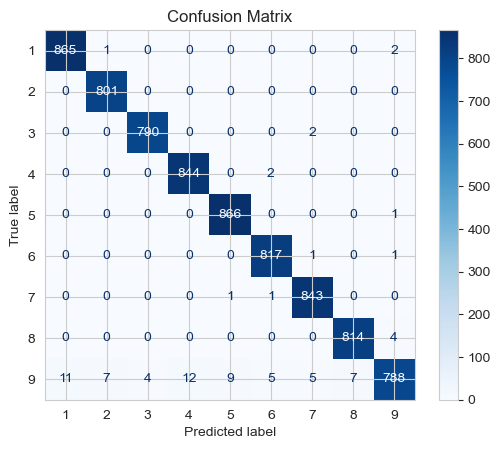

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 预测测试集结果
y_pred = voting_classifier.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()